# Lecture 11

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X = mnist.data
y = mnist.target

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict

In [56]:
sgd_clf = SGDClassifier(random_state=42)
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')
sgd_clf.fit(X_train, y_train_5)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Confusion Matrices

Suppose there is a binary actual target, Positive and Negative. And there is an outcome of classification, Positive and negative. Then you can come up with 4 different combinations of predicated and actual values:

    - true positive
    - false positive (actual target is negative, but the model predicts positive)
        - a.k.a type I error
    - true negative
    - false negative (actual target is positive, but the model predicts negative)
        - type II error

In [11]:
from sklearn.metrics import confusion_matrix

In [17]:
from IPython.display import Image
Image(url="https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0303.png", width=900, height=500)

In case, if you need more concise metric: use *precision* and *recall*

$$\text{precision}=\frac{TP}{TP+FP}$$
$$\text{recall}=\frac{TP}{TP+FN}$$

In [12]:
from sklearn.metrics import precision_score, recall_score
print("precision of 5 detector: {:.03f}".format(precision_score(y_train_5, y_train_pred)))
print("sensitivity of 5 detector: {:.03f}".format(recall_score(y_train_5, y_train_pred)))

precision of 5 detector: 0.837
sensitivity of 5 detector: 0.651


1. Is this a good classifier?
    - Remember that 0 detector showed a higher precision and recall
    - Is this a good claissfier overall or only for identifying 0?
2. When do we need precision over sensitivity? Or sensitivity over precision?

...in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

# The Precision/Recall Trade-off

To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. 

For each instance, it computes *a score* based on a decision function. 

If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [14]:
print(y[0])
y_scores = sgd_clf.decision_function([X[0]])
print(y_scores)

5
[2164.22030239]


In [15]:
# Now based on we can set the threshold arbitrarily
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]
[False]


Now consider the relationship between threshold and precision / recall tradeoff

In [21]:
Image(url="https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0304.png", width=1000, height=500)

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [17]:
y_scores.shape

(60000,)

In [18]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

Now you can guess that what the SGD classifer does

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds (the function adds a last precision of 0 and a last recall of 1, corresponding to an infinite threshold):

In [58]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [60]:
print(precisions.shape)
print(recalls.shape)
print(recalls.shape)

(59967,)
(59967,)
(59967,)


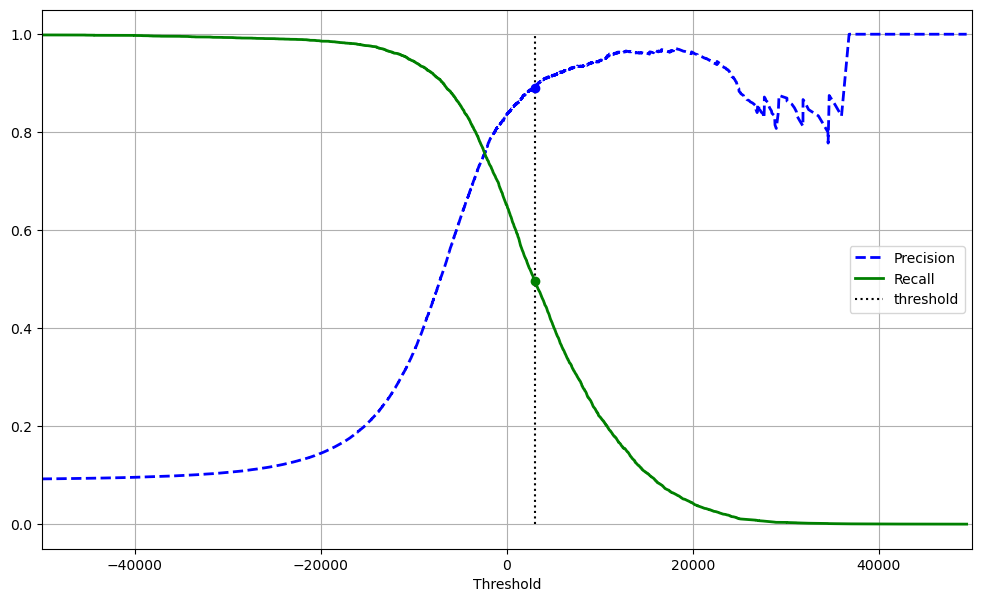

In [32]:
import matplotlib.pyplot as plt

# Note that threshold = 3000 defined ealier

plt.figure(figsize=(12, 7))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies the Figure 
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, -0.05, 1.05])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

At around 3000 threshold value, precision is near 90% and recall is around 50%. 

You may wonder why the precision curve is bumpier than the recall curve. 

- The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up). 
- To understand why, look back at the previous figure and notice what happens when you start from the central threshold and move it just one digit to the right
    - precision goes from 4/5 (80%) down to 3/4 (75%). On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.
    - that is, the denominator does not change continuously (what does the denominator represent?)

Another way to select a good precision/recall trade-off is to plot precision directly against recall

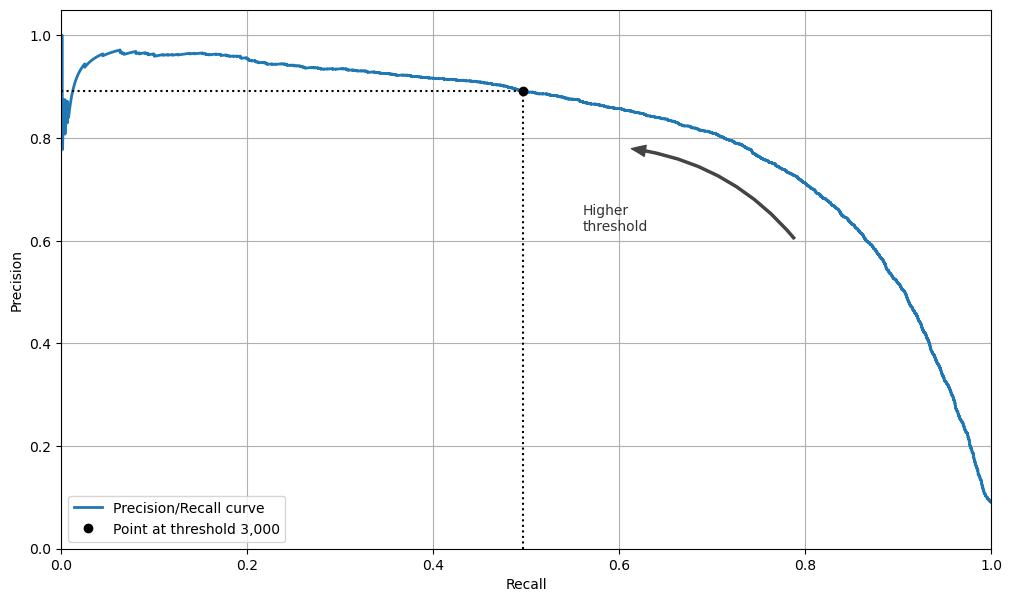

In [36]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(12, 7))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1.05])
plt.grid()
plt.legend(loc="lower left")

plt.show()

You can see that precision really starts to fall sharply at around 80% recall. You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project.

## Finding a benchmark

Suppose you decide to aim for 90% precision. You could use the first plot to find the threshold you need to use, but that’s not very precise. Alternatively, you can search for the lowest threshold that gives you at least 90% precision. For this, you can use the NumPy array’s argmax() method. This returns the first index of the maximum value, which in this case means the first True value:

In [37]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can run this code:

In [38]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [40]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. But wait, not so fast–a high-precision classifier is not very useful if its recall is too low! For many applications, 48% recall wouldn’t be great at all.

# ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers.

It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). 

The FPR (also called the *fall-out*) is the ratio of negative instances that are incorrectly classified as positive.
$$\text{FPR}=\frac{FP}{FP+TN}=1-TNR \; \text{(true negative rate)}$$

$TNR$ is also called *specificty*.

Hence, the ROC curve plots sensitivity (recall) versus $1 – \text{specificity}$.

To plot the ROC curve, you first use the roc_curve() function to compute the TPR and FPR for various threshold values:

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

To find the point that corresponds to 90% precision, we need to look for the index of the desired threshold. Since thresholds are listed in decreasing order in this case, we use <= instead of >= on the first line:

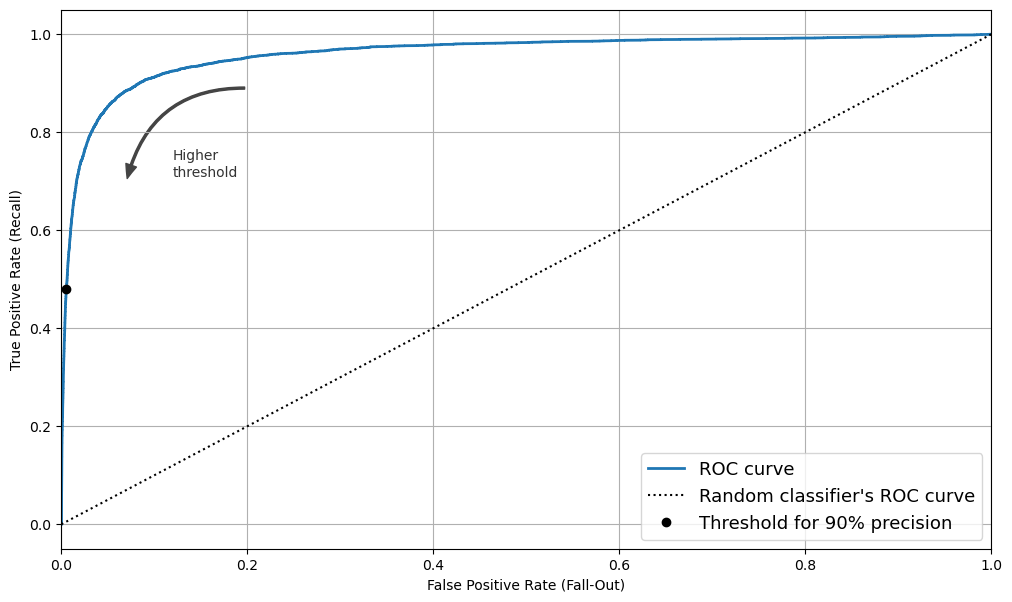

A ROC curve plotting the false positive rate against the true positive rate for all possible thresholds; the black circle highlights the chosen ratio (at 90% precision and 48% recall)


In [48]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(12, 7))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies Figure
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title("")
plt.grid()
plt.axis([0, 1, -0.05, 1.05])
plt.legend(loc="lower right", fontsize=13)
plt.show()
print('A ROC curve plotting the false positive rate against the true positive rate for all possible thresholds; the black circle highlights the chosen ratio (at 90% precision and 48% recall)')

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. 

The dotted line represents the ROC curve of a purely random classifier

    - a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). 

A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

Scikit-Learn provides a function to estimate the ROC AUC:

In [49]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use.

As a rule of thumb, you should prefer the *PR curve* whenever *the positive class is rare* or when you care more about *the false positives* than the false negatives. 

*Otherwise, use the ROC curve.* 

For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement: the curve could really be closer to the top-right corner (see PR curve figure again)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

/Users/yeabinmoon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.9688

In [53]:
sgd_clf.score(X_train, y_train_5)

0.9522666666666667

In [57]:
sgd_clf.score(X_test, y_test_5)

0.9492